# **Data Loading**

In [1]:
import pandas as pd
import argparse
from typing import Dict, Tuple, List

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
CBD_data = pd.read_csv("/content/drive/MyDrive/ReVolt code/CBD")
CBD_data.head()

,Unnamed: 0,Unnamed: 0.1,Degrees,Time,Speed,Energycons,EProp,E_Aux,HVAC,Power,Regen,SoC,driveCycle,city,weather
0,38487,38487,0.0,0.000000e+00,0.000000e+00,NaN,0.000000e+00,5.35,5.2501,10.600,0.0,100.000,CBD,Portland,Summer
1,38488,38488,20.0,5.329100e-15,4.764600e-15,3.008500e+14,2.940200e-13,5.26,5.2500,10.510,0.0,100.000,CBD,Portland,Summer
2,38489,38489,20.1,2.011700e-07,1.798600e-07,2.798700e+10,1.109900e-05,5.26,5.2500,10.510,0.0,100.000,CBD,Portland,Summer
3,38490,38490,20.2,2.880000e-02,2.574900e-02,2.439000e+05,1.589000e+00,5.26,5.2500,12.099,0.0,100.000,CBD,Portland,Summer
4,38491,38491,0.1,6.711200e+00,6.000300e+00,1.812200e+04,8.359500e+01,5.26,5.2500,94.105,0.0,99.877,CBD,Portland,Summer


In [4]:
CBD_data.shape

(2245, 15)

# **Data Cleaning**

Let's add dummies for weather so it will give 0 for summer and 1 for winter, as it will be easier to segregate the data based on seasons for our analysis to compare and contrast.

In [5]:
# Creating a dummy variable for the variable 'city' and dropping the first one.
#city_dummy = pd.get_dummies(UDDS_data['city'],prefix='city',drop_first=False)
#Adding the results to the master dataframe
#UD_data = pd.concat([UDDS_data,city_dummy],axis=1)

# Creating a dummy variable for the variable 'weather' and dropping the first one.
weather_dummy = pd.get_dummies(CBD_data['weather'],prefix='weather',drop_first=True)
#Adding the results to the master dataframe
C_data = pd.concat([CBD_data,weather_dummy],axis=1)

In [6]:
C_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Degrees', 'Time', 'Speed', 'Energycons',
       'EProp', 'E_Aux', 'HVAC', 'Power', 'Regen', 'SoC', 'driveCycle', 'city',
       'weather', 'weather_Winter'],
      dtype='object')

Removing drivecycle and weather columns as we have already reproduced our data in such a way that one file is related to one drive cycle and we have our dummy for weather.

In [7]:
C_data.drop(columns=['weather','driveCycle','Unnamed: 0','Unnamed: 0.1'],inplace=True)

In [8]:
C_data.shape

(2245, 12)

Check for any null values :

In [9]:
C_nocity_data = C_data[['Degrees', 'Time', 'Speed', 'Energycons',
       'EProp', 'E_Aux', 'HVAC', 'Power', 'Regen', 'SoC','weather_Winter']]
df =C_nocity_data.columns.to_series()[np.isnan(C_nocity_data).any()]
df1 =C_nocity_data.columns.to_series()[np.isinf(C_nocity_data).any()]
print(df, df1)

Energycons    Energycons
dtype: object Series([], dtype: object)


Energycons only have nan vakues here and no inf. 
We will check the percent of nan's existence in the data.


In [10]:
100* C_data.isnull().sum() / C_data.shape[0]

Degrees           0.000000
Time              0.000000
Speed             0.000000
Energycons        0.890869
EProp             0.000000
E_Aux             0.000000
HVAC              0.000000
Power             0.000000
Regen             0.000000
SoC               0.000000
city              0.000000
weather_Winter    0.000000
dtype: float64

Energycons consists of 0.8% data of nan values, when combined with 10 cities, so per city with a particular season, removing those values might effect the regression analysis. Hence let's just replace nan values with 0 and continue with the analysis.



In [11]:
C_data.fillna(0,inplace = True)

In [12]:
C_data.shape

(2245, 12)

In [13]:
C_data.to_csv("CBD_final.csv")

The resulting data set has been given the name CBD_final.csv

# **Data Understanding**

Let's check how dependent are the variables on each other using correlation.

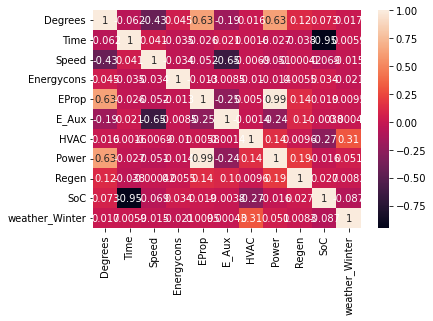

In [14]:
#plotting the heatmap for correlation
hm = sns.heatmap(C_data.corr(), annot=True)

The heatmap suggest that power is dependent on Eprop stronger than that of how it is dependent on degrees. We can predict that this can be because the power is the summation of  E-prop,E-Aux & HVAC. 
In this case, EProp and Power are both are less deperendent on degrees when compared to the strength of dependency as that of power and Eprop.

# **Data Modeling**

Converting the data into Predictor and response sets. Where, the data in X, is used to regress on and the data is y is the dependent varibles and are true output varibles.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

from pandas.core.base import NoNewAttributesMixin


In [16]:
print(C_data['weather_Winter'].unique())

[0 1]


splitting data into winter and summer as per seasons respectively

In [17]:
C= C_data.groupby('weather_Winter')
C_winter = C.get_group(C_data['weather_Winter'].unique()[1])
C_summer = C.get_group(C_data['weather_Winter'].unique()[0])

Train and test split for winter:

In [18]:

new_C_winter = C_winter

CX_winter = new_C_winter[['Degrees', 'Time', 'Speed','weather_Winter']]


CY_winter = new_C_winter[['Energycons', 'EProp', 'E_Aux', 'HVAC',
       'Regen', 'SoC']]



Train and test data for summer: 

In [19]:
new_C_summer = C_summer

CX_summer = new_C_summer[['Degrees', 'Time', 'Speed','weather_Winter']]


CY_summer = new_C_summer[['Energycons', 'EProp', 'E_Aux', 'HVAC',
       'Regen', 'SoC']]

# Linear Regression For MultiTarget Regression:
Applying Linear Regression model and checking the if the prediction is accurate.

### linear regression for winter of all the cities

In [20]:
C_winter_linearmodel = LinearRegression()
# fit model
C_winter_linearmodel.fit(CX_winter, CY_winter)

LinearRegression()

In [21]:
CY_winter_pred = C_winter_linearmodel.predict(CX_winter)
r2_score( np.array(CY_winter), CY_winter_pred,multioutput='uniform_average')

0.34014989692967385

In [22]:
mean_absolute_error( CY_winter, CY_winter_pred)

6896984.533048044

In [23]:
mean_absolute_percentage_error( CY_winter, CY_winter_pred)

3.610946430045551e+20

In [24]:
mean_squared_error( CY_winter, CY_winter_pred)

1.1421166385536116e+16

### Scaling and plotting for linear regression (winter)

As the values are too large, plotting our regression will become more difficult, therefore we will need to scale our values down.

In [25]:
scaler = MinMaxScaler() ##initialize the minmax scaler from sklearn
CY_winter = scaler.fit_transform(CY_winter) ## fit transform on train data
CY_winter_pred = scaler.fit_transform(CY_winter_pred)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


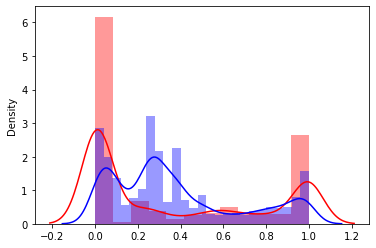

In [26]:
#plt.plot(UDY_winter, UDY_winter_pred, color="b")

ax1 = sns.distplot(CY_winter, color="r", label="Actual Value")
sns.distplot(CY_winter_pred, color="b", label="Fitted Values" , ax=ax1)

### linear regression for summer of all the cities

In [27]:
C_summer_linearmodel = LinearRegression()
# fit model
C_summer_linearmodel.fit(CX_summer, CY_summer)

LinearRegression()

In [28]:
CY_summer_pred = C_summer_linearmodel.predict(CX_summer)
r2_score( np.array(CY_summer), CY_summer_pred,multioutput='uniform_average')

0.3553897271065511

In [29]:
mean_absolute_error( CY_summer, CY_summer_pred)

139084538088.26678

In [30]:
mean_absolute_percentage_error( CY_summer, CY_summer_pred)

7.009632122906427e+24

In [31]:
mean_squared_error( CY_summer, CY_summer_pred)

1.3451117741583427e+25

###Scaling values and plotting: linear regression graph (summer)

In [32]:
CY_summer = scaler.fit_transform(CY_summer) ## fit transform on train data
CY_summer_pred = scaler.fit_transform(CY_summer_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


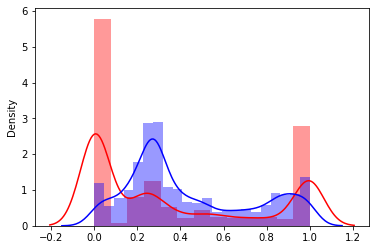

In [33]:
ax1 = sns.distplot(CY_summer, color="r", label="Actual Value")
sns.distplot(CY_summer_pred, color="b", label="Fitted Values" , ax=ax1)

### Conclusion for linear regression :

Clearly, linear regression is not an accurate model for both summer and winter data. My guess here is that the variables are not as dependent as they must be for a linear regression to work.

# **KNN for multioutput Regression**

### KNN for winter of all the cities

In [34]:
KNNmodel = KNeighborsRegressor()
# fit model
KNNmodel.fit(CX_winter, CY_winter)

KNeighborsRegressor()

In [35]:
C_winter_KNNY_pred = KNNmodel.predict(CX_winter)
r2_score( np.array(CY_winter), C_winter_KNNY_pred,multioutput='uniform_average')

0.7237726080179353

In [36]:
mean_absolute_error( CY_winter, C_winter_KNNY_pred)

0.05210010658989225

In [37]:
mean_absolute_percentage_error( CY_winter, C_winter_KNNY_pred)

23609315451173.78

In [38]:
mean_squared_error( CY_winter, C_winter_KNNY_pred)

0.016628517329706275

### Scaling and plotting for KNN (winter)

In [39]:
C_winter_KNNY_pred = scaler.fit_transform(C_winter_KNNY_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


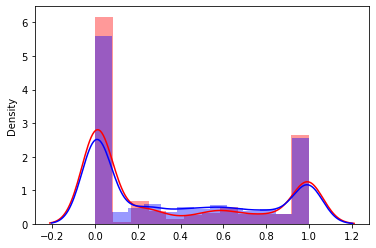

In [40]:
ax1 = sns.distplot(CY_winter, color="r", label="Actual Value")
sns.distplot(C_winter_KNNY_pred, color="b", label="Fitted Values" , ax=ax1)

### KNN for summer of all the cities

In [41]:
# fit model
KNNmodel.fit(CX_summer, CY_summer)

KNeighborsRegressor()

In [42]:
C_summer_KNNY_pred = KNNmodel.predict(CX_summer)
r2_score( np.array(CY_summer), C_summer_KNNY_pred,multioutput='uniform_average')

0.6732611429051426

In [43]:
mean_absolute_error( CY_summer, C_summer_KNNY_pred)

0.04091149262579149

In [44]:
mean_absolute_percentage_error( CY_summer, C_summer_KNNY_pred)

28037699710757.453

In [45]:
mean_squared_error( CY_summer, C_summer_KNNY_pred)

0.012876765619225015

### Scaling and plotting for KNN (summer)

In [46]:
C_summer_KNNY_pred = scaler.fit_transform(C_summer_KNNY_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


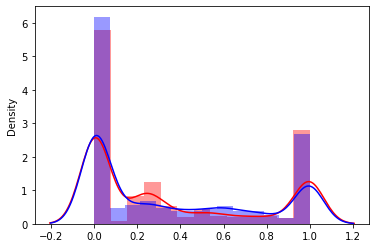

In [47]:
ax1 = sns.distplot(CY_summer, color="r", label="Actual Value")
sns.distplot(C_summer_KNNY_pred, color="b", label="Fitted Values" , ax=ax1)

### Conclusion for KNN :

KNN seems to be a better model for both summer and winter data when compared to that of linear regression. But, it is not the best model as a single model as it's accuracy is only about 78%.

# **Random Forest for multioutput Regression**


### Random forest for winter of all the cities

In [48]:
RFmodel = RandomForestRegressor()
# fit model
RFmodel.fit(CX_winter, CY_winter)

RandomForestRegressor()

In [49]:
C_winter_RFY_pred = RFmodel.predict(CX_winter)
r2_score( np.array(CY_winter), C_winter_RFY_pred,multioutput='uniform_average')

0.9277901934797098

In [50]:
mean_absolute_error( CY_winter, C_winter_RFY_pred)

0.023093972413246854

In [51]:
mean_absolute_percentage_error( CY_winter, C_winter_RFY_pred)

6464038055230.042

In [52]:
mean_squared_error( CY_winter, C_winter_RFY_pred)

0.0038703225902806397

### Scaling and plotting for Random forest (winter)

In [53]:
C_winter_RFY_pred = scaler.fit_transform(C_winter_RFY_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


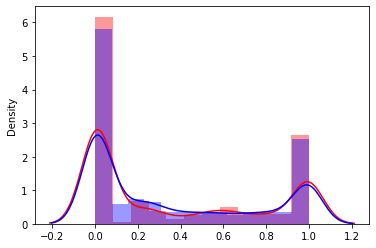

In [54]:
ax1 = sns.distplot(CY_winter, color="r", label="Actual Value")
sns.distplot(C_winter_RFY_pred, color="b", label="Fitted Values" , ax=ax1)

### Random forest for summer of all the cities

In [55]:
RFmodel.fit(CX_summer, CY_summer)

RandomForestRegressor()

In [56]:
C_summer_RFY_pred = RFmodel.predict(CX_summer)
r2_score( np.array(CY_summer), C_summer_RFY_pred,multioutput='uniform_average')

0.911142421027903

In [57]:
mean_absolute_error( CY_summer, C_summer_RFY_pred)

0.017331525450183075

In [58]:
mean_absolute_percentage_error( CY_summer, C_summer_RFY_pred)


10198820775081.674

In [59]:
mean_squared_error( CY_summer, C_summer_RFY_pred)

0.002962833873798228

### Scaling and plotting for Random forest (summer)

In [60]:
C_summer_RFY_pred = scaler.fit_transform(C_summer_RFY_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


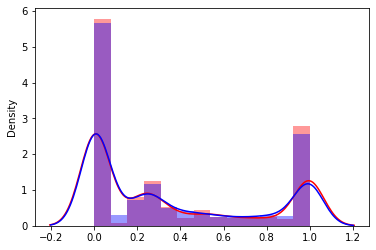

In [61]:
ax1 = sns.distplot(CY_summer, color="r", label="Actual Value")
sns.distplot(C_summer_RFY_pred, color="b", label="Fitted Values" , ax=ax1)

### Conclusion for KNN :
Random forest seems to be the best model for the data with 95% accuracy and the graph shows how accurate the predicted values are to that of actual values.

# **MultiOutput Regression using XGBoost:**

### XGBoost for winter of all the cities

In [62]:
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:linear')).fit(CX_winter, CY_winter)
C_winter_XGBY_pred= multioutputregressor.predict(CX_winter)

[02:13:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [63]:
r2_score( np.array(CY_winter), C_winter_XGBY_pred ,multioutput='uniform_average')

0.8131004977485401

In [64]:
mean_absolute_error( CY_winter, C_winter_XGBY_pred)

0.04538424639001115

In [65]:
mean_absolute_percentage_error( CY_winter, C_winter_XGBY_pred)

15050782001493.518

In [66]:
mean_squared_error( CY_winter, C_winter_XGBY_pred)

0.014054739360720816

### Scaling and plotting for XGBoost (winter)

In [67]:
C_winter_XGBY_pred = scaler.fit_transform(C_winter_XGBY_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


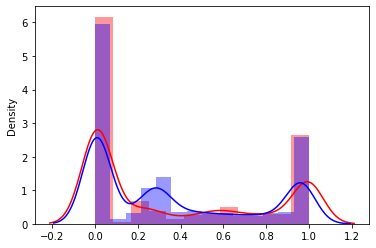

In [68]:
ax1 = sns.distplot(CY_winter, color="r", label="Actual Value")
sns.distplot(C_winter_XGBY_pred, color="b", label="Fitted Values" , ax=ax1)

### XGBoost for summer of all the cities

In [69]:
multioutputregressor.fit(CX_summer, CY_summer)
C_summer_XGBY_pred= multioutputregressor.predict(CX_summer)

[02:13:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [70]:
r2_score( np.array(CY_summer), C_summer_XGBY_pred ,multioutput='uniform_average')

0.8285573693432546

In [71]:
mean_absolute_error( CY_summer, C_summer_XGBY_pred)

0.035963845540578014

In [72]:
mean_absolute_percentage_error( CY_summer, C_summer_XGBY_pred)


22230817777657.574

In [73]:
mean_squared_error( CY_summer, C_summer_XGBY_pred)

0.010502828548285026

### Scaling and plotting for XGBoost (summer)

In [74]:
C_summer_XGBY_pred = scaler.fit_transform(C_summer_XGBY_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


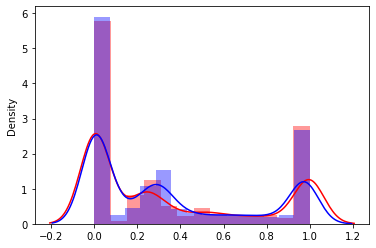

In [75]:
ax1 = sns.distplot(CY_summer, color="r", label="Actual Value")
sns.distplot(C_summer_XGBY_pred, color="b", label="Fitted Values" , ax=ax1)

###Conclusion for XGBoost :
XGBoost model is almost like KNN model but better, having an accuracy rate of 81%